# 概要

因果グラフ（DAG）を用いて、selection on observableの仮定を置いて因果推論する場合、欠落変数バイアスが起きないように適切なDAGを設定する必要がある。

通常、DAGはドメイン知識に基づいて作られるが、データにもとづいてDAGを推定しようとするのが因果探索（causal discovery）の分野。

## Causal Assumptions

[[2303.15027] A Survey on Causal Discovery Methods for I.I.D. and Time Series Data](https://arxiv.org/abs/2303.15027)

グラフィカルモデルで因果探索するための仮定

1. 因果マルコフ条件（Causal Markov Condition）
2. 忠実性（Faithfulness）
3. 因果的十分性（Causal Sufficiency）
4. 非巡回性（Acyclicity）


### 仮定(1)：因果マルコフ条件（Causal Markov Condition）

各ノード$X_i \in X$が親ノードで条件づけられた場合、非子孫ノードとは条件付き独立の関係にある。


例：連鎖構造
- グラフ： $X \to Y \to Z$
- このとき： $Z \perp X \mid Y$（$Y$ を条件づけると $X$ と $Z$ は独立）


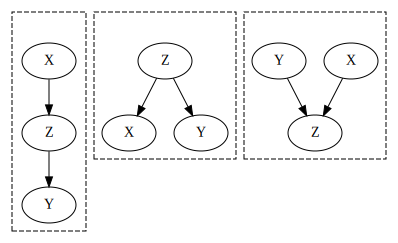

In [7]:
import graphviz

graphviz.Source("""
digraph G {
  rankdir=TB;

  subgraph cluster_chain {
    label="連鎖経路";
    style=dashed;
    X1 [label="X"];
    Z1 [label="Z"];
    Y1 [label="Y"];
    X1 -> Z1 -> Y1;
  }

  subgraph cluster_fork {
    label="分岐経路";
    style=dashed;
    Z2 [label="Z"];
    X2 [label="X"];
    Y2 [label="Y"];
    Z2 -> X2;
    Z2 -> Y2;
  }

  subgraph cluster_collider {
    label="合流経路";
    style=dashed;
    X3 [label="X"];
    Y3 [label="Y"];
    Z3 [label="Z"];
    X3 -> Z3;
    Y3 -> Z3;
  }
}
""")

### 仮定(2)：忠実性（Faithfulness）

d分離（d-separation、ノード$X, Y$を別のノード集合$\mathcal{S}$でブロックしている状態） 以外に統計的独立（$Cov(X, Y) = 0$） が成り立たないことを **忠実性** という。


忠実性が満たされない例は次の画像のようなグラフ。$X_3$に対して$X_1 \to X_3$と$X_2 \to X_3$の2つの影響が加わるため、両者の効果が相殺されて$X_2 \to X_3$が見かけ上独立になることが考えられる。

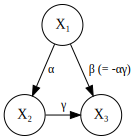

In [6]:
import graphviz

graphviz.Source("""
digraph G {
  rankdir=TB;
  node [shape=circle, fontsize=14];

  X1 [label="X₁"];
  X2 [label="X₂"];
  X3 [label="X₃"];

  // rank same 指定
  { rank = same; X2; X3; }

  // edges with labels
  X1 -> X2 [label="α", fontsize=12];
  X2 -> X3 [label="γ", fontsize=12];
  X1 -> X3 [label="β (= -αγ)", fontsize=12];
}
""")

### 仮定(3)：因果的十分性（Causal Sufficiency）

未観測の交絡因子が存在しないという仮定。

### 仮定(4)：非巡回性（Acyclicity）

DAGであるという仮定。

## 因果探索手法の分類

主に4つのアプローチがある

1. 制約ベース
2. スコアベース
3. 関数因果モデル
4. 勾配ベースモデル

|        | **① 制約ベース** | **② スコアベース** | **③ 関数因果モデル**（非ガウス性・非線形性の活用） | **④ 勾配ベース** |
|--------|------------------|---------------------|---------------------------------------------------------|------------------|
| **静的** | PC, FCI, RFCI | GES, TTPM, BIC-GES | LiNGAM, PNL, ANM, HPCI, NICA-LiNGAM                   | NOTEARS, NOTEARS-GOLEM, GAE, CORL |
| **動的** | PCMCI, PCMCI+  | SVAR-FCI, tsGES     | VAR-LiNGAM, TiMINo, DAG-GNN (time series version)      | Dynotears, cNOTEARS |




### 制約ベース（constraint based)

条件付き独立性のパターンから、DAGの構造（因果構造）を推定（学習）する手法群。  
独立性／非独立性の "制約 (constraints)" を満たすDAGを探すため、constraint-based と呼ばれる。

代表例：PCアルゴリズム

### スコアベース（score based）

モデルの「当てはまりの良さ」を測るスコアを定義し、因果グラフの集合の中から最も良いグラフを探し出すアプローチ。

代表例：GESアルゴリズム

### 関数因果モデル

非対称性を用いるアプローチ。

例えばLiNGAMは誤差項の確率分布がガウス分布（正規分布）に従わない線形モデルのDAGを推定する。正規分布でなく、因果の方向性がわかることを利用する


### 勾配ベース

制約ベースやスコアベースの場合、ノードの組み合わせを最適化する非凸組合せ最適化問題として解くため、計算量が多くて効率的に最適化ができない。

そこで微分可能な連続最適化問題として解くのが勾配ベースのアルゴリズム。

代表例：NOTEARS

## 専門用語まとめ

### マルコフ同値類

:::{admonition} マルコフ同値類

同じ条件付き独立性を与える因果グラフの集合を **マルコフ同値類（Markov equivalence class: MEC）** という。

例えば、

- DAG1: X → Y → Z
- DAG2: X ← Y → Z

はいずれも$X\perp Z \mid Y$であるため、マルコフ同値類の要素である。


因果探索において、MECから因果グラフを一意に特定するのが難しい

:::

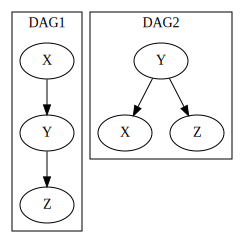

In [19]:
import graphviz

graphviz.Source("""
digraph G {
  rankdir=TB;

  subgraph cluster_chain {
    X1 [label="X"];
    Y1 [label="Y"];
    Z1 [label="Z"];
    X1 -> Y1;
    Y1 -> Z1;
    label="DAG1";
  }

  subgraph cluster_fork {
    X2 [label="X"];
    Y2 [label="Y"];
    Z2 [label="Z"];
    Y2 -> X2;
    Y2 -> Z2;
    label="DAG2";
  }
}
""")